# Introduction

Reliability is one of the three most important parameters in a train service, the other two being safety and cost. Singaporeans today enjoy a relatively high standard of rail reliability, which is a luxury in some other parts of the world. This project examines the rail network of New Jersey, whose reliabilty levels are significantly lower than that of ours, and explores how operational parameters could have affect the reliabilty of their train service.

To provide some context, Singapore's trains clock over [1,000,000km](https://www.straitstimes.com/singapore/transport/mrt-hits-new-reliability-high-at-mid-year) before encountering a failure. This corresponding figure for New Jersey Transit is [93,000km](https://www.nj.com/news/2021/01/nj-transit-trains-ranked-the-worst-in-the-nation-again.html). Similarly, our train commuter satisfaction score is usually around [7.7](https://www.ptc.gov.sg/newsroom/news-releases/newsroom-view/commuters-satisfied-with-public-transport-in-2020), while that of New Jersey Transit (NJT) is [5.2](https://www.njtransit.com/surveyresults). These figures demonstrate how poor the reliability of New Jersey's rail transportation is, and it might be worth investigating the underlying factors behind this.

Rail reliabilty levels are often quantified by the train delay timings, and a train failure is usually defined as a delay of more than 5 minutes. Therefore, we will explore how various operating factors such as weather, route, distance, or crowd, could have contributed to train delays. From the perspective of the commuter, it is also useful to have an understanding of what kinds of delays are likely to happen given a set of predictors. 

In [1]:
#Setting Up the Notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

sns.set_context('notebook', font_scale=1.25, rc={"lines.linewidth": 2.5})
sns.set_style("darkgrid")
np.random.seed(123)  # For reproducibility

# Methodology and Dataset
The response variable we are studying is the delay time of the train service. In the first part of our study, we will perform a regression to identify the quantitative factors that could have contributed to an increase in delay times. 

In the second part of the study, we will classify the delay times by severity and analyse the associated predictors. This perspective is useful because commuters might not be so interested in the exact quantitative relationship between the predictors and delays, and might instead be more interested in a rough sensing of how bad their train delays could be. From the perspective of the operator, delay times above a certain duration usually incur punitive measures, so it might be worth studying this particular class of failures in greater detail. We will adopt decision trees and a neural network to do this classification, and compare their performance with the regression model. 

In the third part of the study, we use unsupervised learning to focus our analysis on the more significant delays, which form a very small proportion of our dataset. We will adopt Gaussian Mixture Models to predict whether a delay would be signficant, and use Principal Component Analysis to identify hidden relationships among these attributes.

Let us now examine our dataset. Our dataset contains the following predictors:
 * train_id: the identification number of the train
 * stop_sequence: the ith stop that the train would make as it traverses its route
 * from_id: the station that the train departs from
 * scheduled_time: the time the train should arrive at the station
 * line: route of the train
 * type: operator of the train

In [2]:
rail_data = pd.read_csv('./data/NJRail_filtered.csv') 
rail_data.head()

,date,train_id,stop_sequence,from,from_id,to,to_id,scheduled_time,actual_time,delay_minutes,status,line,type
0,1/5/2020,951,2,Hoboken,63,Newark Broad Street,106,1/5/2020 5:11,1/5/2020 5:15,4.100000,departed,Morristown Line,NJ Transit
1,1/5/2020,951,4,East Orange,37,Brick Church,23,1/5/2020 5:18,1/5/2020 5:22,4.216667,departed,Morristown Line,NJ Transit
2,1/5/2020,951,7,Highland Avenue,61,Mountain Station,97,1/5/2020 5:25,1/5/2020 5:29,4.133333,departed,Morristown Line,NJ Transit
3,1/5/2020,951,9,South Orange,140,Maplewood,81,1/5/2020 5:31,1/5/2020 5:35,4.183333,departed,Morristown Line,NJ Transit
4,1/5/2020,70,5,Campbell Hall,26,Salisbury Mills-Cornwall,135,1/5/2020 5:32,1/5/2020 5:36,4.016667,departed,Main Line,NJ Transit


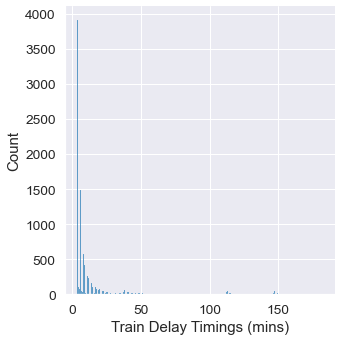

In [3]:
#Visualise Distribution of Train Delay Timings
sns.displot(x=rail_data['delay_minutes'])
plt.xlabel("Train Delay Timings (mins)")
plt.ylabel("Count")
plt.tight_layout()

From the distribution of the train delay timings, we observe that the train delay times are heavily skewed towards minor delays. Note that this observation is based on a filtered dataset that removes minor delays of less than 4mins. Had those data points not been removed, the minor delays would have further crowded out the major ones and slowed the run time significantly.

Also from the dataset, we notice that the number of predictors is quite limited, and that some predictors might be correlated with each other (stop_sequence and from_id). Additionally, we only have one ordinal parameter (stop_sequence). To make our analysis more meaningful, we augmented the dataset with the following predictors:
 * Weather predictors: temperature, humidity, wind speed, gust speed, weather condition
 * Population predictors: population, population density of township that the station is located in
 * Coordinate predictors: longitude and latitude of each station to estimate the station-to-station distance, municipality of each station to relate to population data

In [4]:
weather_data = pd.read_csv('./data/NJRail_weather.csv', encoding='windows-1252')
weather_data.head()

,Date,Time,Temperature,Humidity (%),Wind Speed,Gust Speed,Condition
0,1/5/2020,23:51,55 F,96,3 mph,0 mph,Light Rain
1,1/5/2020,0:51,56 F,97,8 mph,0 mph,Light Rain
2,1/5/2020,1:22,54 F,100,3 mph,0 mph,Light Rain
3,1/5/2020,1:51,55 F,96,7 mph,0 mph,Light Rain
4,1/5/2020,2:32,54 F,100,5 mph,0 mph,Fog


In [5]:
population_data = pd.read_csv('./data/NJRail_population.csv')
population_data.head()

,County,AreaName,LandArea (sq mi),Population,Density
0,1,Absecon city,5.4,8283,1535.1
1,1,Atlantic City city,10.7,38429,3575.8
2,1,Brigantine city,6.4,8963,1403.2
3,1,Buena borough,7.6,4429,584.5
4,1,Buena Vista township,41.1,7422,180.8


In [6]:
coordinates_data = pd.read_csv('./data/NJRail_coordinates.csv')
coordinates_data.head()

,STATION_ID,COUNTY,LATITUDE,LONGITUDE,MUNICIPALITY,RAIL_SERVICE
0,Point Pleasant Beach,Ocean,40.09272,-74.04819,Point Pleasant Beach,NC
1,Spring Lake,Monmouth,40.15057,-74.03546,Spring Lake,NC
2,Belmar,Monmouth,40.18059,-74.02730,Belmar,NC
3,Bradley Beach,Monmouth,40.20378,-74.01896,Neptune Twp,NC
4,Asbury Park,Monmouth,40.21536,-74.01479,Asbury Park,NC


In [7]:
"""
This section creates the functions to integrate the datasets
"""

#this function takes the names of the source and destination stations and returns the approximate distance between them
def get_distance(source_station, destination_station):

    #Extract Location Coordinates of Station
    source_station = source_station.replace("Lvl", "Level")
    destination_station = destination_station.replace("Lvl", "Level")
    source_lat = coordinates_data.loc[coordinates_data['STATION_ID'].str.match(source_station), 'LATITUDE']
    source_long = coordinates_data.loc[coordinates_data['STATION_ID'].str.match(source_station), 'LONGITUDE']
    dest_lat = coordinates_data.loc[coordinates_data['STATION_ID'].str.match(destination_station), 'LATITUDE']
    dest_long = coordinates_data.loc[coordinates_data['STATION_ID'].str.match(destination_station), 'LONGITUDE']   
    source_lat = source_lat.to_numpy()[0]
    source_long = source_long.to_numpy()[0]
    dest_lat = dest_lat.to_numpy()[0]
    dest_long = dest_long.to_numpy()[0]

    #Convert Coordinates to Distance
    lat_distance = (dest_lat - source_lat) * 110947.2
    long_distance = (dest_long - source_long) * 87843.36
    
    #Calculate Distance
    return round(np.sqrt(lat_distance**2 + long_distance**2), 3)/1000 #convert to km

#this function takes the date and time and returns the weather at that time
def get_weather(timestamp):

    #Extract Time Information
    date = timestamp.split(" ")[0]
    time = timestamp.split(" ")[1]
    hour = int(time.split(":")[0])
    
    #Match Time Information
    matching_hour = []
    date = weather_data.loc[weather_data['Date'].str.match(date)]
    for i in range(len(date.index)):
        weather_data_date = str(date.iloc[i]['Time'])
        weather_data_hour = int(weather_data_date.split(':')[0])
        if (weather_data_hour == hour):
            matching_hour.append(date.iloc[i])
            break
    if (len(matching_hour) == 0):
        raise Exception('No matching date and time info found!')
    matching_hour = matching_hour[0]
    
    #Extract Weather Information
    temp = str(matching_hour['Temperature'])
    temp = float(temp[:-2])
    temp = round((temp-32)*5/9, 2) #convert to degrees
    hum = int(matching_hour['Humidity (%)'])
    wind = str(matching_hour['Wind Speed'])
    wind = int(wind[:-4])
    gust = str(matching_hour['Gust Speed'])
    gust = int(gust[:-4])
    
    return temp, hum, wind, gust

#this function takes the name of the source station and returns the population of the town that the station is located in
def get_population(source_station):

    #Extract Station Location
    source_station = source_station.replace("Lvl", "Level")
    location = coordinates_data.loc[coordinates_data['STATION_ID'].str.match(source_station)]
    location = str(location['MUNICIPALITY'])
    location = location.replace("Twp", "township")
    
    #Find Population at Location
    pattern = "    (.*?)\n"
    population = re.search(pattern, location).group(1)
    population = population.lstrip()
    population = population_data.loc[population_data['AreaName'].str.match(population)]
    population = str(population['Population'])
    
    return int(re.search(pattern, population).group(1))

In [8]:
"""
This section handles the preprocessing and takes about 2 minutes to run.
"""

#Clean Data
rail_data_clean = rail_data.drop(rail_data[rail_data.status=="cancelled"].index)
rail_data_clean = rail_data_clean.dropna()

#Integrate Datasets
distance_array = []
temperature_array = []
humidity_array = []
wind_speed_array = []
gust_speed_array = []
population_array = []
scheduled_hour_array = []

for i in range(len(rail_data_clean.index)):
    temp = rail_data_clean.iloc[i]
    distance = get_distance(str(temp['from']), str(temp['to']))
    temperature, humidity, wind_speed, gust_speed = get_weather(str(temp['scheduled_time']))
    population = get_population(str(temp['from']))
    scheduled_hour = str(temp['scheduled_time']).split(" ")[1]
    scheduled_hour = int(scheduled_hour.split(":")[0])
    
    distance_array.append(distance)
    temperature_array.append(temperature)
    humidity_array.append(humidity)
    wind_speed_array.append(wind_speed)
    gust_speed_array.append(gust_speed)
    population_array.append(population)
    scheduled_hour_array.append(scheduled_hour)

rail_data_clean['Distance'] = distance_array
rail_data_clean['Temperature'] = temperature_array
rail_data_clean['Humidity'] = humidity_array
rail_data_clean['Wind Speed'] = wind_speed_array
rail_data_clean['Gust Speed'] = gust_speed_array
rail_data_clean['Population'] = population_array
rail_data_clean['Scheduled Hour'] = scheduled_hour_array

At this juncture, it is good examine the integrated dataset and how correlated the features are. From the correlation matrix below, we see that the features are relatively uncorrelated, with the exception of wind speed and gust speed. This is not surprising, since gust is just a faster and more instantaneous wind. Therefore, we shall select just one of the two (gust speed) for our subsequent regression and classification analysis.

In [9]:
rail_data_clean

,date,train_id,stop_sequence,from,from_id,to,to_id,scheduled_time,actual_time,delay_minutes,status,line,type,Distance,Temperature,Humidity,Wind Speed,Gust Speed,Population,Scheduled Hour
0,1/5/2020,951,2,Hoboken,63,Newark Broad Street,106,1/5/2020 5:11,1/5/2020 5:15,4.100000,departed,Morristown Line,NJ Transit,12.716319,12.22,97,3,0,55131,5
1,1/5/2020,951,4,East Orange,37,Brick Church,23,1/5/2020 5:18,1/5/2020 5:22,4.216667,departed,Morristown Line,NJ Transit,0.881262,12.22,97,3,0,65378,5
2,1/5/2020,951,7,Highland Avenue,61,Mountain Station,97,1/5/2020 5:25,1/5/2020 5:29,4.133333,departed,Morristown Line,NJ Transit,1.509866,12.22,97,3,0,30813,5
3,1/5/2020,951,9,South Orange,140,Maplewood,81,1/5/2020 5:31,1/5/2020 5:35,4.183333,departed,Morristown Line,NJ Transit,2.090261,12.22,97,3,0,17001,5
4,1/5/2020,70,5,Campbell Hall,26,Salisbury Mills-Cornwall,135,1/5/2020 5:32,1/5/2020 5:36,4.016667,departed,Main Line,NJ Transit,14.535502,12.22,97,3,0,5509,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13136,15/5/2020,1701,17,Ramsey Route 17,38417,Mahwah,78,16/5/2020 2:37,16/5/2020 2:45,8.150000,departed,Main Line,NJ Transit,2.146865,20.56,78,10,0,15242,2
13137,15/5/2020,1701,18,Mahwah,78,Suffern,144,16/5/2020 2:41,16/5/2020 2:48,7.000000,estimated,Main Line,NJ Transit,2.208794,20.56,78,10,0,26759,2
13138,15/5/2020,7805,14,Jersey Avenue,32906,Princeton Junction,125,16/5/2020 2:42,16/5/2020 2:54,12.050000,departed,Northeast Corrdr,NJ Transit,22.499034,20.56,78,10,0,57073,2
13139,15/5/2020,7805,15,Princeton Junction,125,Hamilton,32905,16/5/2020 2:49,16/5/2020 3:01,12.150000,departed,Northeast Corrdr,NJ Transit,9.780646,20.56,78,10,0,28491,2


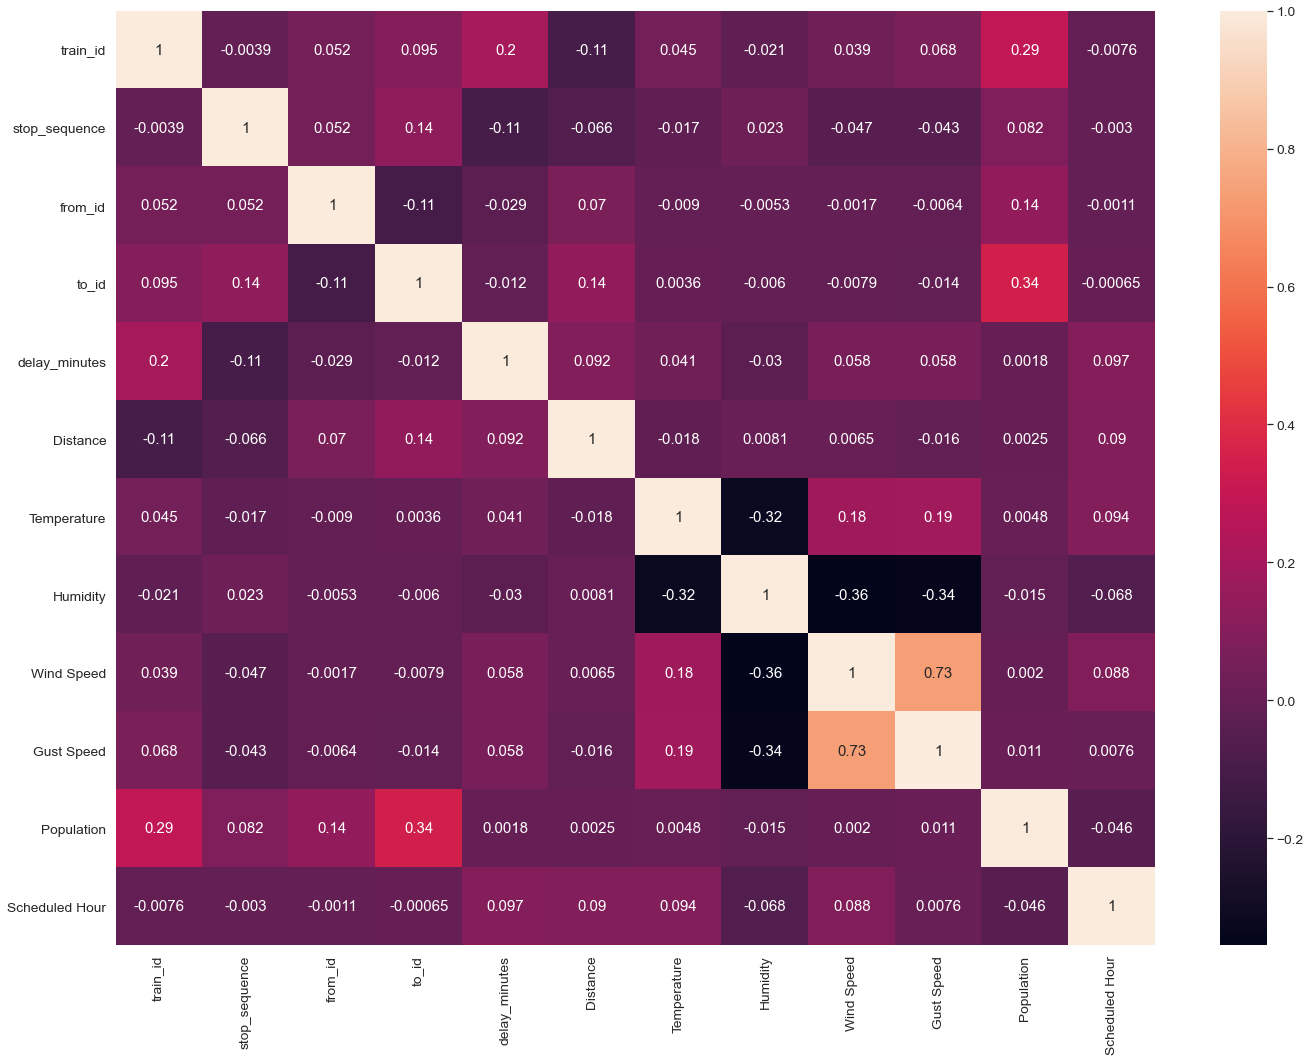

In [10]:
#Correlation Matrix
corrMatrix = rail_data_clean.corr()
plt.subplots(figsize=(20,15))
sns.heatmap(corrMatrix, annot=True)
plt.tight_layout()

# Kernel Regression
Another two predictors that should be exlcuded from our regression analysis are the from_id and to_id. These predictors are not actually ordinal as they are merely numerical representations of the station names, and the order of the stations is already represented by stop_sequence. We are now ready to perform a kernel ridge regression using the gaussian kernel.

In [11]:
from sklearn.preprocessing import MinMaxScaler

#Define Predictors
X = ['stop_sequence', 'Distance', 'Temperature', 'Humidity', 'Gust Speed', 'Population', 'Scheduled Hour']
inputs = rail_data_clean[rail_data_clean.columns.intersection(X)]

#Define Response
outputs = rail_data_clean['delay_minutes']

#Scale Data
scaler = MinMaxScaler()

In [12]:
"""
This section performs the Gaussian Kernel Regression with CV and takes about 2 minutes to run.
"""

from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.model_selection import cross_val_score

kf = KFold(n_splits=5)
clf_rbf = KernelRidge(kernel="rbf", gamma=0.5)
y_hat_array_rbf = []
outputs_aggregate = []
MSE_rbf = 0

for train, test in kf.split(inputs):
    x_train_normalized = scaler.fit_transform(inputs.iloc[train])
    x_test_normalized = scaler.transform(inputs.iloc[test])
    clf_rbf.fit(x_train_normalized, outputs.iloc[train])
    y_hat_rbf = clf_rbf.predict(x_test_normalized)
    
    for i in range(len(outputs.iloc[test])):
        outputs_aggregate.append(outputs.iloc[test[i]])
        y_hat_array_rbf.append(y_hat_rbf[i])
        MSE_rbf += (y_hat_rbf[i] - outputs.iloc[test[i]])**2

MSE: 458.7797640159371
RMSE: 21.419144801227173
Scaled RMSE: 0.8443866741559171


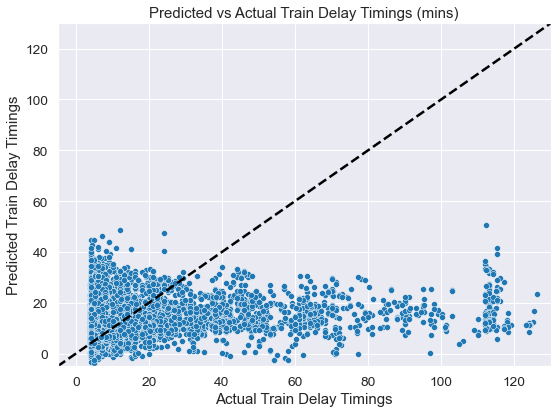

In [13]:
#Quantify Errors
MSE_rbf = MSE_rbf / len(outputs)
RMSE = np.sqrt(MSE_rbf)
scaled_RMSE = RMSE/(np.sqrt(np.mean(outputs**2)))
print("MSE:", MSE_rbf)
print("RMSE:", RMSE)
print("Scaled RMSE:", scaled_RMSE)

#Visualise Results
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(x=outputs_aggregate, y=y_hat_array_rbf, ax=ax)
plt.title("Predicted vs Actual Train Delay Timings (mins)")
plt.xlabel("Actual Train Delay Timings")
plt.ylabel("Predicted Train Delay Timings")
plt.xlim(-5, 130)
plt.ylim(-5, 130)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls='--', c='k')
fig.tight_layout()

Quantitatively, we observe that the rbf kernel regression does not perform well as the scaled RMSE is 0.844. This gives us an error rate of about 84%. The plot above gives some clue as to why this might be so. Upon closer examination, we realise that our dataset is overcrowded by minor delays of 0-20 minutes. In this region, our model performs slightly better as the data points are somewhat closer to the dashed line. Note that this does not necessarily imply that the model is good, because we see that the data points span the whole square (4,0) to (20,20). This means that specific predictions in this interval can still be highly inaccurate. Beyond the 0-20mins region, our model fails to make good predictions at all. As MSE penalises a model more heavily for more egregious prediction errors, the resultant MSE of this model becomes very high.

It is worth noting that <b> if </b> the full unfiltered dataset had been used, the rbf kernel would have actually done a "good job" in predicting the delay timings and achieved an error rate of about 4.4%. However, this figure would be misleading because of the skewed dataset; if the model had blindly guessed a small delay time of 0-2mins, it would have most likely have been close to the actual delay time. Because of the sheer number of small delays (40,000 of the 80,000 delays were 0-2mins), the MSE would not increase much even if we had a few egregious prediction errors of 100mins.

Given the poor performance of the regression model, adding and tuning a penalty term is unlikely to improve the model significantly. It might perhaps be more fruitful to explore the problem from a classification angle using a different type of model.

# Decision Trees
We adopt a decision tree to predict the severity of the delay given the same predictors. We split the delay timings into a few classes: mild (<10mins), moderate (10-30mins), major (30-60mins), and severe (>60mins).

In [14]:
#Classify Delay Times
delay_class = []
for j in rail_data_clean['delay_minutes']:
    if (j<10):
        delay_class.append(0)
    elif (10<=j<30):
        delay_class.append(1)
    elif (30<=j<60):
        delay_class.append(2)
    else:
        delay_class.append(3)

outputs_class = delay_class

Test Accuracy: 0.8126428027418127


C:\Users\tan_n\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


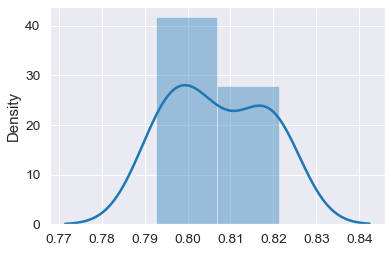

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

#Perform Decision Tree Classification
x_train, x_test, y_train, y_test = train_test_split(inputs, outputs_class, test_size=0.1)
clf_tree = DecisionTreeClassifier(max_depth=10)
clf_tree.fit(x_train, y_train)

#Quantify Classification Results
test_accuracy_tree = clf_tree.score(x_test, y_test)
print('Test Accuracy:', test_accuracy_tree)
scores = cross_val_score(clf_tree, x_train, y_train, cv=10)
sns.distplot(scores)
fig.tight_layout()

We observe that the classification score of the decision tree of is 0.813, and that this figure is close to that of the training set. While it is not possible to directly to compare the performance of the regression and classification model, the classification score of the decision tree seems to be much higher than the R2 score the regression model. However, we should investigate whether this good classification applies to the more major delays, or whether the model is just classifying many minor delays correctly. We do this by visualising the decision tree.

[Text(1559.0898186294212, 1297.2272727272727, 'Distance <= 8.593\ngini = 0.412\nsamples = 11812\nvalue = [8820, 1923, 566, 503]\nclass = Mild'),
 Text(694.9418458601286, 1173.6818181818182, 'Distance <= 1.488\n0.34\n9834\n[7858, 1381, 325, 270]\nMild'),
 Text(276.4909063504823, 1050.1363636363635, 'Scheduled Hour <= 12.5\n0.551\n1341\n[844, 203, 76, 218]\nMild'),
 Text(103.72789389067523, 926.590909090909, 'Distance <= 0.412\n0.372\n457\n[347, 104, 6, 0]\nMild'),
 Text(44.85530546623794, 803.0454545454545, 'Scheduled Hour <= 2.5\n0.553\n87\n[41, 41, 5, 0]\nMild'),
 Text(17.942122186495176, 679.5, 'Scheduled Hour <= 0.5\n0.145\n26\n[1, 24, 1, 0]\nModerate'),
 Text(8.971061093247588, 555.9545454545455, 'Humidity <= 58.5\n0.5\n2\n[1, 1, 0, 0]\nMild'),
 Text(4.485530546623794, 432.4090909090909, '0.0\n1\n[0, 1, 0, 0]\nModerate'),
 Text(13.456591639871382, 432.4090909090909, '0.0\n1\n[1, 0, 0, 0]\nMild'),
 Text(26.913183279742764, 555.9545454545455, 'Temperature <= 5.0\n0.08\n24\n[0, 23, 1,

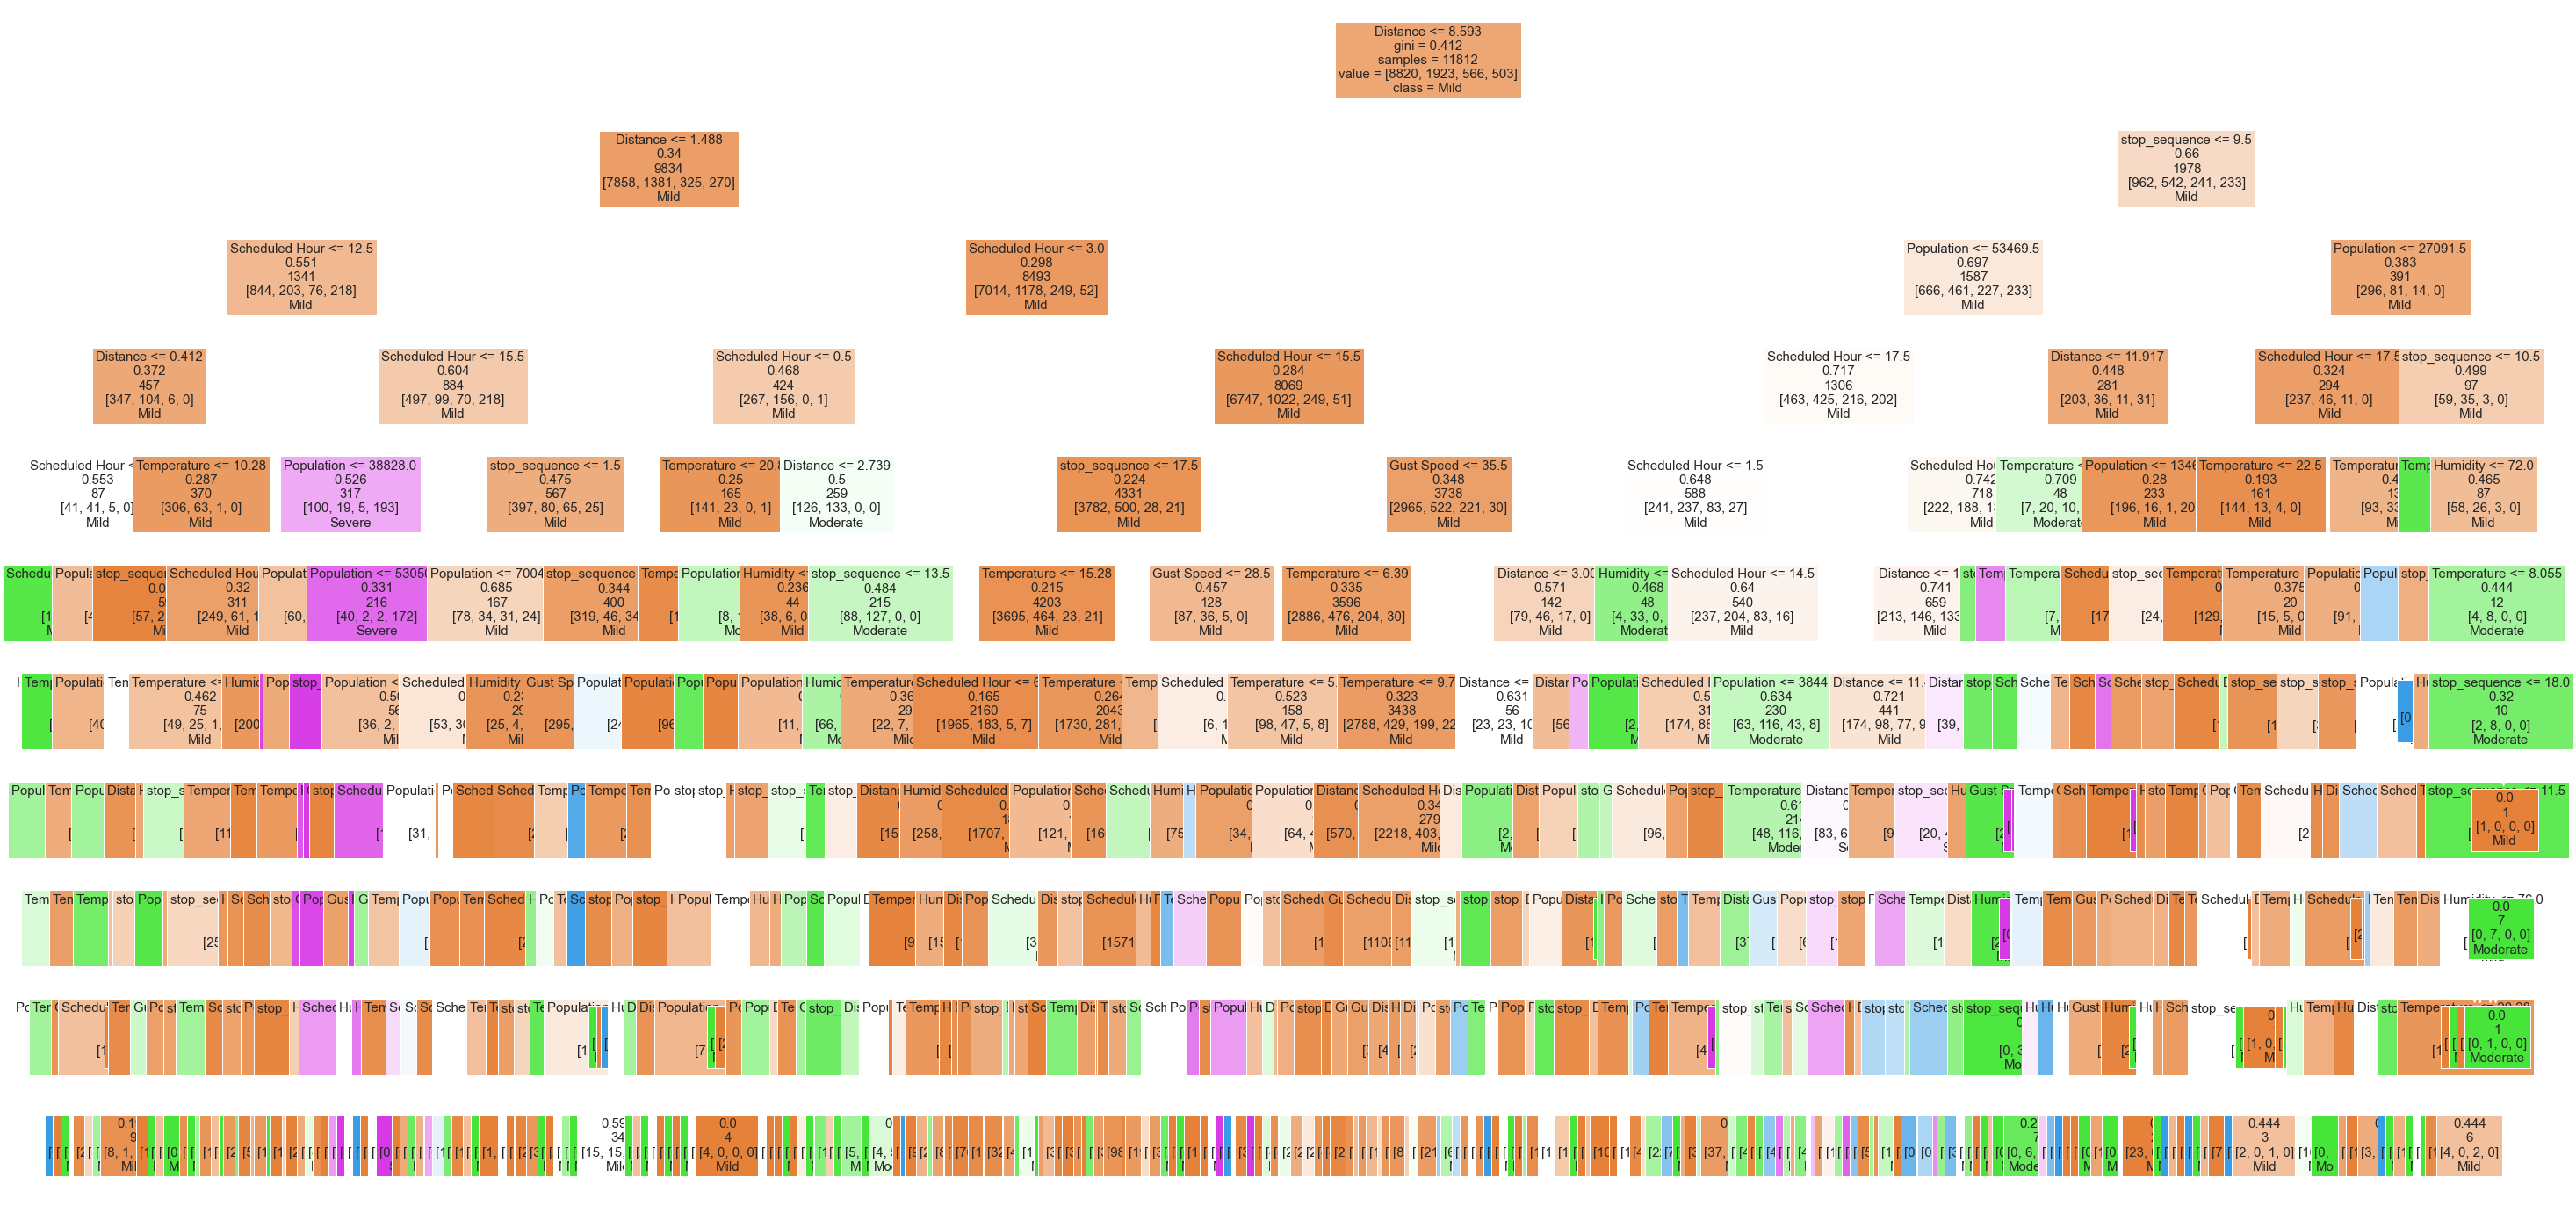

In [16]:
"""
This section visualises the decision tree and takes about 2 minutes to run.
"""

from sklearn.tree import plot_tree
from sklearn import tree

#Visualising Decision Tree
plt.figure(figsize=(50, 25))
plot_tree(clf_tree, label='root', feature_names=inputs.columns, class_names=['Mild', 'Moderate', 'Major', 'Severe'], filled=True, fontsize=15)

Even though the decision tree is very large, it is rather easy to apprise it and obtain quick insights. For example, we observe that the gini coefficients of the boxes are in general quite low, which means that the purity of the predicted classes are quite high. This agrees with the high classification accuracy we obtained earlier. We also observe that the boxes of strong colours (more purely classified) are distributed across each of the classes, so it is not the case that only mild delays are well classified. From the text output, we can also study the decision tree more thoroughly. For example, we can filter out the delays that are severe and examine the gini coefficient specific to those severe delays.

Another important factor to examine is the degree of overfitting. For a sample size of around 11,000, there are 845 nodes in total, so each node should have about 13 elements. Nonetheless, we can see from the tree there are some nodes with just 1 element. Therefore, we will examine how the classification accuracy will change with varying tree depths, and whether ensembling techniques can help to improve this accuracy further.

In [17]:
"""
This section explores varying the decision tree depth and bagging. It takes about 2 minutes to run.
"""

from sklearn.ensemble import RandomForestClassifier

results_tree = []
results_forest= []

for depth in range(9, 15):
    
    #Decision Tree
    clf_tree = DecisionTreeClassifier(max_depth=depth)
    clf_tree.fit(x_train, y_train)
    test_acc_tree = clf_tree.score(x_test, y_test)
    cv_acc_tree = np.mean(cross_val_score(clf_tree, x_train, y_train, cv=10))
    results_tree.append([depth, cv_acc_tree, test_acc_tree])
    
    #Random Forest
    clf_forest = RandomForestClassifier(max_depth=depth)
    clf_forest.fit(x_train, y_train)
    test_acc_forest = clf_forest.score(x_test, y_test)
    cv_acc_forest = np.mean(cross_val_score(clf_forest, x_train, y_train, cv=10))
    results_forest.append([depth, cv_acc_forest, test_acc_forest])
    
results_tree = pd.DataFrame(data=results_tree, columns=['depth', 'test accuracy', 'cv accuracy'])
results_tree = pd.melt(results_tree, id_vars=['depth'], var_name='type', value_name='accuracy')
results_forest = pd.DataFrame(data=results_forest, columns=['depth', 'test accuracy', 'cv accuracy'])
results_forest = pd.melt(results_forest, id_vars=['depth'], var_name='type', value_name='accuracy')

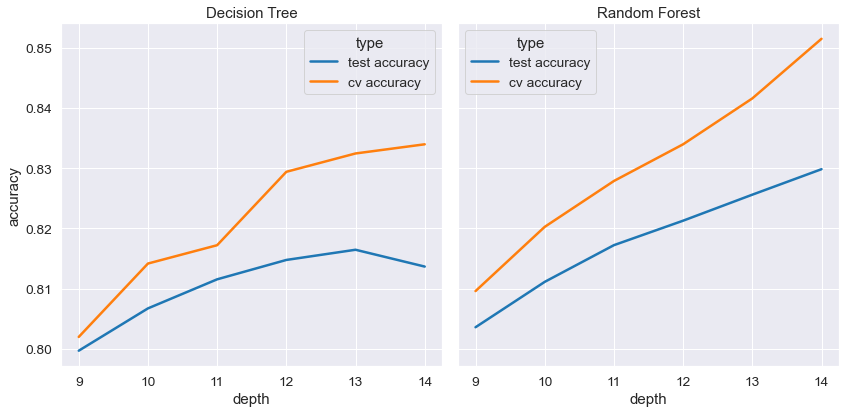

In [18]:
#Visualise Results
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
sns.lineplot(x='depth', y='accuracy', hue='type', data=results_tree, ax=ax[0])
ax[0].set_title('Decision Tree')
sns.lineplot(x='depth', y='accuracy', hue='type', data=results_forest, ax=ax[1])
ax[1].set_title('Random Forest')
fig.tight_layout()

For Decision Trees, we observe that our model generally perfoms better when we increase the depth. The classification accuracy peaks at depth=13. For Random forests, we observe that the model performs better for each depth. This is because bagging tends to reduce the variance of the model. For this model, we observe that the optimal depth has yet to be found, and we can do so by further increasing the depth to find where the test accuracy peaks. However, for the purpose of comparison, let's examine how the performance of this Random Forest model compares to another type of classification model.

# Neural Network

We expand our list of predictors to include some nominal variables and examine whether they make our predictions better. We will include the 'line' and 'from' variables. If it were the case that certain lines are more prone to delays than others, or rail service from certain stations are more prone to delays than others, then we might see improvements in our classification. We first normalise each of our predictors and encode our nominal predictors.

In [19]:
from sklearn.preprocessing import StandardScaler

#Normalize Predictors
stop_sequence_norm = rail_data_clean['stop_sequence']
distance_norm = rail_data_clean['Distance']
temperature_norm = rail_data_clean['Temperature']
humidity_norm = rail_data_clean['Humidity']
gust_speed_norm = rail_data_clean['Gust Speed']
population_norm = rail_data_clean['Population']
hour_norm = rail_data_clean['Scheduled Hour']

#Encode Nominal Predictors
station_norm = rail_data_clean['from_id']

line_norm = []
for k in rail_data_clean['line']:
    if (k=='Atl. City Line'):
        line_norm.append(1)
    elif (k=='Bergen Co. Line' or 'Bergen Co. Line '):
        line_norm.append(2)
    elif (k=='Gladstone Branch'):
        line_norm.append(3)
    elif (k=='Main Line'):
        line_norm.append(4)
    elif (k=='Montclair-Boonton'):
        line_norm.append(5)
    elif (k=='Morristown Line'):
        line_norm.append(6)
    elif (k=='No Jersey Coast'):
        line_norm.append(7)
    elif (k=='Northeast Corrdr'):
        line_norm.append(8)
    elif (k=='Pasack Valley'):
        line_norm.append(9)
    elif (k=='Princeton Shuttle'):
        line_norm.append(10)
    elif (k=='Raritan Valley'):
        line_norm.append(11)
    else:
        raise Exception("Missing Line!")

#Scale Data
data = {'stop_sequence_norm': stop_sequence_norm, 'distance_norm': distance_norm, 'temperature_norm': temperature_norm,
       'humidity_norm': humidity_norm, 'gust_speed_norm': gust_speed_norm, 'population_norm': population_norm,
       'hour_norm': hour_norm, 'station_norm': station_norm, 'line_norm': line_norm}
inputs2 = pd.DataFrame(data=data)
scaler = StandardScaler()
inputs2 = scaler.fit_transform(inputs2)

In [20]:
import tensorflow as tf

#Process Data for Neural Network
inputs2 = np.array(inputs2)
outputs_class = np.array(outputs_class)
x_train, x_test, y_train, y_test = train_test_split(inputs2, outputs_class, test_size=0.1)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)

In [21]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

#Build Neural Network
x = Input(shape=(9,))
x_1 = Dense(units=16, activation='relu')(x)
x_2 = Dense(units=4, activation='softmax')(x_1)
nn = Model(inputs=x, outputs=x_2)
nn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
dense (Dense)                (None, 16)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 68        
Total params: 228
Trainable params: 228
Non-trainable params: 0
_________________________________________________________________


In [22]:
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import SGD

#Fit Neural Network
nn.compile(loss=categorical_crossentropy, optimizer=SGD(0.01), metrics=['accuracy'])
initial_weights = nn.get_weights()
results = nn.fit(x=x_train,y=y_train, batch_size=64, epochs=10, validation_data=(x_test, y_test), verbose=2)

Epoch 1/10
185/185 - 0s - loss: 1.1624 - accuracy: 0.5715 - val_loss: 0.8880 - val_accuracy: 0.7738
Epoch 2/10
185/185 - 0s - loss: 0.8520 - accuracy: 0.7595 - val_loss: 0.7745 - val_accuracy: 0.7860
Epoch 3/10
185/185 - 0s - loss: 0.7795 - accuracy: 0.7706 - val_loss: 0.7304 - val_accuracy: 0.7867
Epoch 4/10
185/185 - 0s - loss: 0.7452 - accuracy: 0.7705 - val_loss: 0.7051 - val_accuracy: 0.7860
Epoch 5/10
185/185 - 0s - loss: 0.7247 - accuracy: 0.7706 - val_loss: 0.6894 - val_accuracy: 0.7867
Epoch 6/10
185/185 - 0s - loss: 0.7113 - accuracy: 0.7710 - val_loss: 0.6776 - val_accuracy: 0.7867
Epoch 7/10
185/185 - 0s - loss: 0.7017 - accuracy: 0.7704 - val_loss: 0.6698 - val_accuracy: 0.7867
Epoch 8/10
185/185 - 0s - loss: 0.6946 - accuracy: 0.7701 - val_loss: 0.6635 - val_accuracy: 0.7860
Epoch 9/10
185/185 - 0s - loss: 0.6891 - accuracy: 0.7712 - val_loss: 0.6582 - val_accuracy: 0.7860
Epoch 10/10
185/185 - 0s - loss: 0.6849 - accuracy: 0.7719 - val_loss: 0.6542 - val_accuracy: 0.7860

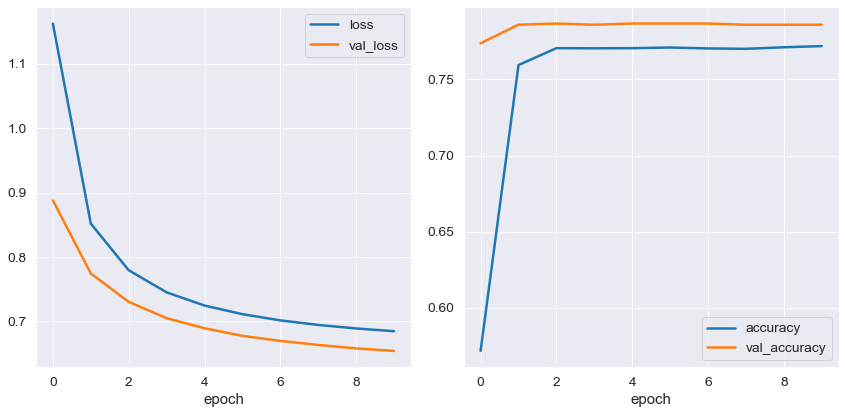

In [23]:
#Visualise Results
results_df = pd.DataFrame(results.history)
results_df['epoch'] = results.epoch
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
results_df.plot(x='epoch', y=['loss', 'val_loss'], ax=ax[0])
results_df.plot(x='epoch', y=['accuracy', 'val_accuracy'], ax=ax[1])
fig.tight_layout()

From the above plots, we observe that the neural network performs decently well for classification, and has an accuracy of around 0.78 on the test set. This is slightly lower than that of the decision tree. In the next segment, we explore how we can tune hyperparameters like the batch size to optimise the neural network performance. Another way of improving the neural network performance might be to use one-hot encoding of the station or line parameters as this might more accurately represent the independent relationship among predictors (e.g. 2 Newark Broad Street is not equal to 1 Princeton Junction). This however, would increase our dataset dimensions significantly (there are 160 stations) and complicate subsequent analysis.

We also observe potential signs of overfitting from the plots as the validation accuracy remains approximately the same even though the validation loss drops over time. Therefore, while it is possible to tune other parameters like the depth and breadth of our neural network, our model already risks being overfitted, so increasing these hyperparameters might make the model more complex and have little impact on our validation accuracy.

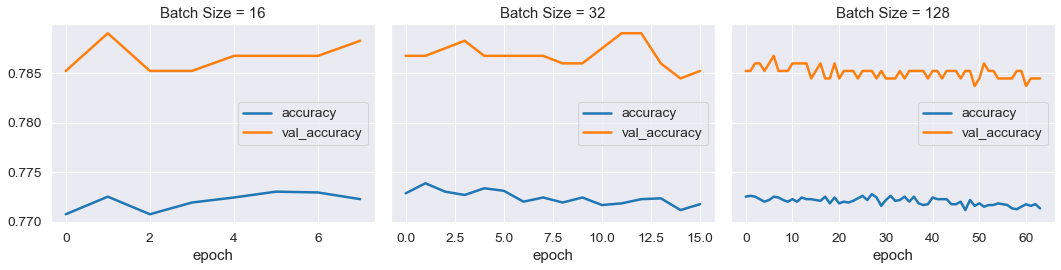

In [24]:
"""
This section explores varying the batch size to optimise the neural network. It takes about 2 minutes to run.
"""

#Hyperparameter Tuning of Batch Size
results_16 = nn.fit(x=x_train,y=y_train, batch_size=16, epochs=8, validation_data=(x_test, y_test), verbose=0)
results_16_df = pd.DataFrame(results_16.history)
results_16_df['epoch'] = results_16.epoch

results_32 = nn.fit(x=x_train,y=y_train, batch_size=32, epochs=16, validation_data=(x_test, y_test), verbose=0)
results_32_df = pd.DataFrame(results_32.history)
results_32_df['epoch'] = results_32.epoch

results_128 = nn.fit(x=x_train,y=y_train, batch_size=128, epochs=64, validation_data=(x_test, y_test), verbose=0)
results_128_df = pd.DataFrame(results_128.history)
results_128_df['epoch'] = results_128.epoch

#Visualise Results
fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
results_16_df.plot(x='epoch', y=['accuracy', 'val_accuracy'], ax=ax[0], title='Batch Size = 16')
results_32_df.plot(x='epoch', y=['accuracy', 'val_accuracy'], ax=ax[1], title='Batch Size = 32')
results_128_df.plot(x='epoch', y=['accuracy', 'val_accuracy'], ax=ax[2], title='Batch Size = 128')
fig.tight_layout()

Notwithstanding the fluctuations in validation accuracy across the epochs, we observe that increasing the batch sizes generally does not help much with the the validation accuracy or training accuracy. Let's instead examine our results by class.

In [25]:
#Quantify Results by Class
y_hat_test = nn.predict(x_test)
minor_correct = moderate_correct = major_correct = severe_correct = 0
minor_wrong = moderate_wrong = major_wrong = severe_wrong = 0

for m in range(len(y_hat_test)):
    if (np.argmax(y_hat_test[m]) == 0):
        if (np.argmax(y_hat_test[m]) == np.argmax(y_test[m])):
            minor_correct += 1
        else:
            minor_wrong += 1
    if (np.argmax(y_hat_test[m]) == 1):
        if (np.argmax(y_hat_test[m]) == np.argmax(y_test[m])):
            moderate_correct += 1
        else:
            moderate_wrong += 1
    if (np.argmax(y_hat_test[m]) == 2):
        if (np.argmax(y_hat_test[m]) == np.argmax(y_test[m])):
            major_correct += 1
        else:
            major_wrong += 1
    if (np.argmax(y_hat_test[m]) == 3):
        if (np.argmax(y_hat_test[m]) == np.argmax(y_test[m])):
            severe_correct += 1
        else:
            severe_wrong += 1

print('Minor delays:', minor_correct, 'classified correctly and', minor_wrong, 'classified wrongly')
print('Moderate delays:', moderate_correct, 'classified correctly and', moderate_wrong, 'classified wrongly')
print('Major delays:', major_correct, 'classified correctly and', major_wrong, 'classified wrongly')
print('Severe delays:', severe_correct, 'classified correctly and', severe_wrong, 'classified wrongly')

Minor delays: 1001 classified correctly and 220 classified wrongly
Moderate delays: 24 classified correctly and 46 classified wrongly
Major delays: 4 classified correctly and 9 classified wrongly
Severe delays: 1 classified correctly and 8 classified wrongly


Examining the results of neural network by class, we realise that we encounter the same problem with the regression - minor delays crowding out the major delays. Hence even though our classification score seems decent, our model is only predicting a lot of minor delays well, and the rest rather poorly. Given how skewed the dataset is, it might be good to consider unsupervised learning to focus our analysis on major and severe delays.

# Gaussian Mixture Models
We consider a Gausian Mixture Model (GMM) to perform unsupervised density estimation. This will help to identify which predictors are in general more correlated with major and severe delays, and examine whether GMM can use these predictors to predict major and severe delays. As we want to focus on these more significant of delays, we shall re-classify our data into two classes: 
 * Class 0: Mild and Moderate
 * Class 1: Major and Severe

We will adopt our set of predictors used for the neural network which contains value-encoded predictors (for line and station). Therefore, when examining the distributions below, we will focus more on the shape and location of the distribution instead of the numerical values on the x axis.

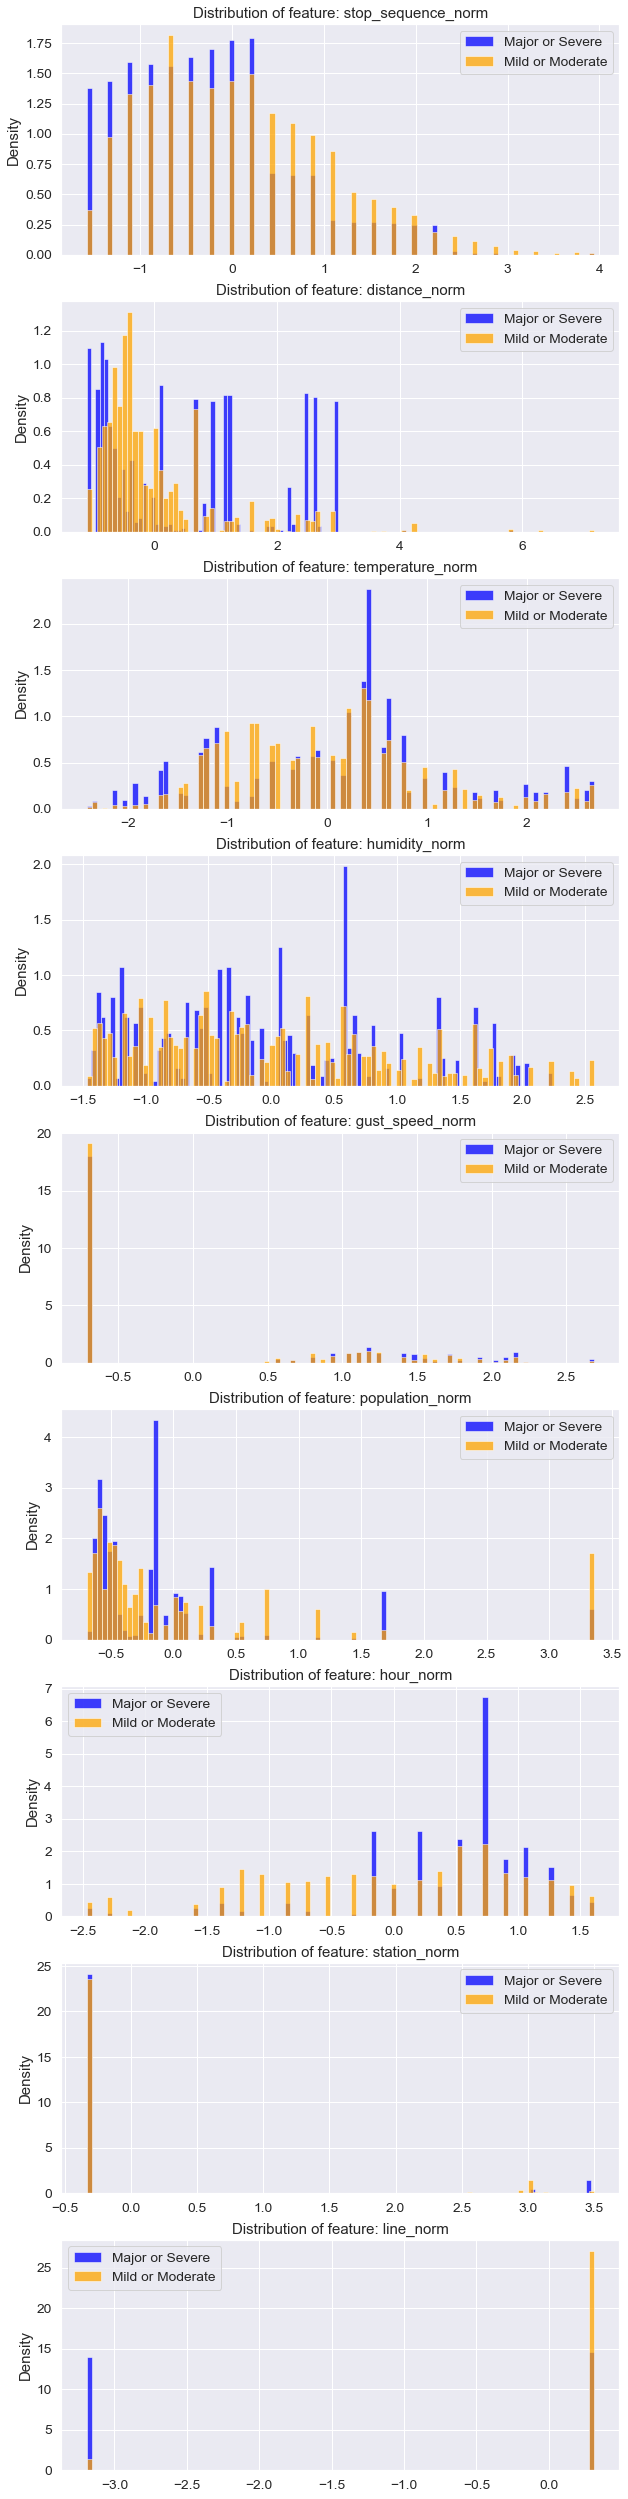

In [26]:
"""
This section studys the distribution of the predictors and displays it by severity class. It takes about 1 minute to run.
"""

import matplotlib.gridspec as gridspec

#Process Data for GMM
outputs_class_severity=[]
for c in outputs_class:
    if (c==0 or c==1):
        outputs_class_severity.append(0)
    else:
        outputs_class_severity.append(1)

data = pd.DataFrame(data=inputs2)
data.columns = ['stop_sequence_norm', 'distance_norm', 'temperature_norm', 'humidity_norm', 'gust_speed_norm',
                'population_norm', 'hour_norm', 'station_norm', 'line_norm']
data['Severity_Class'] = outputs_class_severity
        
#Visualise Distribution by Feature
fig, ax = plt.subplots(len(data.columns)-1, 1, figsize=(10, 5*(len(data.columns)-1)))
for (f, a) in zip(data.columns, ax):
    sns.histplot(data[f][data.Severity_Class==1], bins=100, ax=a, color='blue', stat='density')
    sns.histplot(data[f][data.Severity_Class==0], bins=100, ax=a, color='orange', stat='density')
    a.legend(['Major or Severe', 'Mild or Moderate'])
    a.set_xlabel('')
    a.set_title('Distribution of feature: ' + f)

From the distribution plots above, it is difficult to identify predictors that can clearly distinguish between the two classes. We shall pick the top two features where the distributions have least overlap: distance_norm and hour_norm.

In [27]:
#Split Dataset into Class 0 and Class 1
data_0 = data[data.Severity_Class==0]
data_1 = data[data.Severity_Class==1]

data_0=data_0[['distance_norm', 'hour_norm', 'Severity_Class']]    
data_1=data_1[['distance_norm', 'hour_norm', 'Severity_Class']]

#Split Training and Testing Data
x_train, x_test, y_train, y_test = train_test_split(data_0.drop(['Severity_Class'], axis=1), data_0['Severity_Class'],
                                                    test_size=0.1) #Use 90% of Class 0 Data for Training
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(data_1.drop(['Severity_Class'], axis=1), data_1['Severity_Class'],
                                                            test_size=0.5,) #Use 50% of Class 1 Data for Testing

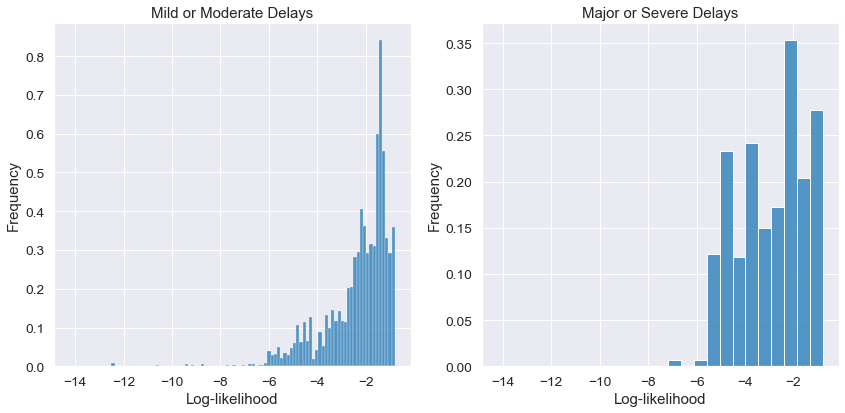

In [28]:
from sklearn.mixture import GaussianMixture

#Build GMM
gmm = GaussianMixture(n_components=5)
gmm.fit(x_train)

#Visualise Results
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True)
sns.histplot(gmm.score_samples(x_train), stat='density', ax=ax[0])
sns.histplot(gmm.score_samples(x_train_1), stat='density', ax=ax[1])
ax[0].set_title('Mild or Moderate Delays')
ax[1].set_title('Major or Severe Delays')
for a in ax:
    a.set_xlabel('Log-likelihood')
    a.set_ylabel('Frequency')
fig.tight_layout()

The above log-likelihood plots tell us how likely delays of each class will be generated by our GMM. This will help us to set a reasonable threshold that can be used to approximately separate the two classes. From the plots, we can see that there is no clear threshold that would nicely separate the Mild/Moderate Delays from the Major/Severe Delays as they both spread across the range of the x-axis. However, we shall still try to find a reasonable threshold that will allow us to pick up a portion of the Major/Severe delays while leaving our a portion of the Mild/Moderate Delays. This will help us to build a classifier for Major/Severe Delays.

In [29]:
#Define Function to Evaluate 
from sklearn.metrics import precision_recall_fscore_support

def evaluate_threshold(x, y, thresholds):
    log_likelihoods = gmm.score_samples(x)
    precisions = []
    recalls = []
    f1s = []
    for t in thresholds:
        y_pred = 1 * (log_likelihoods < t)
        p, r, f1, _ = precision_recall_fscore_support(y, y_pred, average='binary')
        precisions.append(p)
        recalls.append(r)
        f1s.append(f1)
    return precisions, recalls, f1s

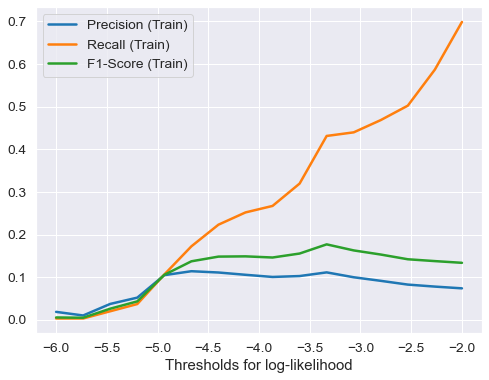

In [30]:
#Build Classifier by Varying Threshold
x_train_combined = np.concatenate([x_train, x_train_1])
y_train_combined = np.concatenate([y_train, y_train_1])
thresholds = np.linspace(-6, -2, 16)
p_train, r_train, f1_train = evaluate_threshold(x_train_combined, y_train_combined, thresholds)

#Visualise Results
plt.figure(figsize=(8, 6))
plt.plot(thresholds, p_train, label='Precision (Train)')
plt.plot(thresholds, r_train, label='Recall (Train)')
plt.plot(thresholds, f1_train, label='F1-Score (Train)')
plt.xlabel('Thresholds for log-likelihood')
plt.legend()
plt.show()

To evaluate our classifier, we use the precision and recall metrics. A good summary statistic is the F1-score. Based on the F1-score, we observe that our classifier performs performance peaks when the threshold is about -3.6. Beyond this point, our F1-score decreases even though the recall keeps improving. This means that even though we can increase the threshold to detect more Major/Severe Delays, we end up accidentally detecting more Minor/Moderate Delays as well. To quantify this performance, we evaluate our classifier with the test set.

In [31]:
from sklearn.metrics import classification_report

#Quantify Classifier Performance
chosen_threshold = thresholds[np.argmax(f1_train)]
x_test_combined = np.concatenate([x_test, x_test_1])
y_test_combined = np.concatenate([y_test, y_test_1])
y_test_pred = gmm.score_samples(x_test_combined) < chosen_threshold
print(classification_report(y_test_combined, y_test_pred))

              precision    recall  f1-score   support

           0       0.74      0.81      0.78      1195
           1       0.53      0.43      0.48       592

    accuracy                           0.69      1787
   macro avg       0.64      0.62      0.63      1787
weighted avg       0.67      0.69      0.68      1787



From the results above, we observe that the F1-score of our model can make reasonable predictions for both classes and outperforms the neural network for Major/Severe Delays. While our GMM can predict Major/Severe Delays correctly about 55% of the time, it still misses out the bulk of Major/Severe Delays as the recall is only 43%. In the context of rail delays, it might be prudent to give more weight to recall because the impact of incurring a Major/Severe Delay is significantly worse than that of accidentally incurring a Minor/Moderate Delay. This will slightly lower the F1-score but better suit our context.

# Principal Component Analysis
The Principal Component Analysis (PCA) is a useful tool for dimensionality reduction and identifying hidden relationship among the predictors. Recall from the GMM distribution plot for line_norm that the distribution of faults was very sparse and unequal for both Minor/Moderate Delays and Major/Severe Delays. This implies that just a few particular lines are contributing to the delays. 

In the previous sections where we value-encoded the line predictor, the impact that each line has on the delays could not be elucidated. Therefore, in this section, we will perform one-hot encoding for the line predictor and make each line a unique predictor of its own. We will perform two sets of PCAs, one for Minor/Moderate Delays and the other for Major/Severe Delays, and examine the impact that the line predictors have on these delays.

In [32]:
"""
This section handles the preprocessing of data for the PCA
"""

#Define Predictors
X = ['stop_sequence', 'from_id', 'line', 'Distance', 'Temperature', 'Humidity', 'Gust Speed', 'Population', 'Scheduled Hour']
inputs3 = rail_data_clean[rail_data_clean.columns.intersection(X)]
inputs3['Severity_Class'] = outputs_class_severity

#Split Dataset into Class 0 and Class 1
inputs3_0 = inputs3[inputs3.Severity_Class==0]
inputs3_1 = inputs3[inputs3.Severity_Class==1]
inputs3_0.pop('Severity_Class')
inputs3_1.pop('Severity_Class')

#One-hot Encode Nominal Predictors
inputs3_0 = pd.get_dummies(inputs3_0)
inputs3_1 = pd.get_dummies(inputs3_1)

#Scale Data
inputs3_0_norm = (inputs3_0 - inputs3_0.min()) / (inputs3_0.max() - inputs3_0.min())
inputs3_1_norm = (inputs3_1 - inputs3_1.min()) / (inputs3_1.max() - inputs3_1.min())
inputs3_0_norm

<ipython-input-32-fb3f5973d94e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inputs3['Severity_Class'] = outputs_class_severity


,stop_sequence,from_id,Distance,Temperature,Humidity,Gust Speed,Population,Scheduled Hour,line_Atl. City Line,line_Bergen Co. Line,line_Gladstone Branch,line_Main Line,line_Montclair-Boonton,line_Morristown Line,line_No Jersey Coast,line_Northeast Corrdr,line_Pascack Valley,line_Princeton Shuttle,line_Raritan Valley
0,0.04,0.001422,0.320452,0.379906,0.964706,0.0,0.191952,0.217391,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.12,0.000826,0.022208,0.379906,0.964706,0.0,0.227949,0.217391,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.24,0.001376,0.038049,0.379906,0.964706,0.0,0.106525,0.217391,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.32,0.003188,0.052675,0.379906,0.964706,0.0,0.058005,0.217391,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.16,0.000573,0.366296,0.379906,0.964706,0.0,0.017635,0.217391,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13136,0.64,0.881141,0.054101,0.680230,0.741176,0.0,0.051826,0.086957,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13137,0.68,0.001766,0.055662,0.680230,0.741176,0.0,0.092284,0.086957,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13138,0.52,0.754736,0.566977,0.680230,0.741176,0.0,0.198774,0.086957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
13139,0.56,0.002844,0.246473,0.680230,0.741176,0.0,0.098368,0.086957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


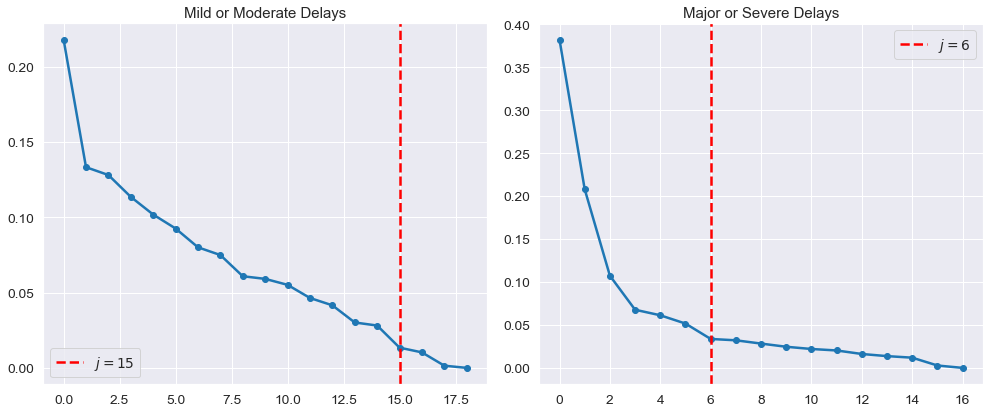

In [33]:
from sklearn.decomposition import PCA

#Build PCA Model
pca_0 = PCA()
pca_1 = PCA()
pca_0.fit(inputs3_0_norm)
pca_1.fit(inputs3_1_norm)

#Visualise Results
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].plot(pca_0.explained_variance_, '-o')
ax[0].axvline(x=15, c='r', ls='--', label=r'$j=15$')
ax[0].legend()
ax[0].set_title('Mild or Moderate Delays')

ax[1].plot(pca_1.explained_variance_, '-o')
ax[1].axvline(x=6, c='r', ls='--', label=r'$j=6$')
ax[1].legend()
ax[1].set_title('Major or Severe Delays')
fig.tight_layout()

Using the elbow method, we find that the Mild/Moderate Delays require 15 of the 19 predictors before the remaining eigenvalues becomes negligibly small, while the Major/Severe Delays require just 6. This means that the Major/Severe Delays require less principal components to achieve the same proportion of explained variance as the Mild/Moderate Delays. Let us visualise the top three principal components for each class below.

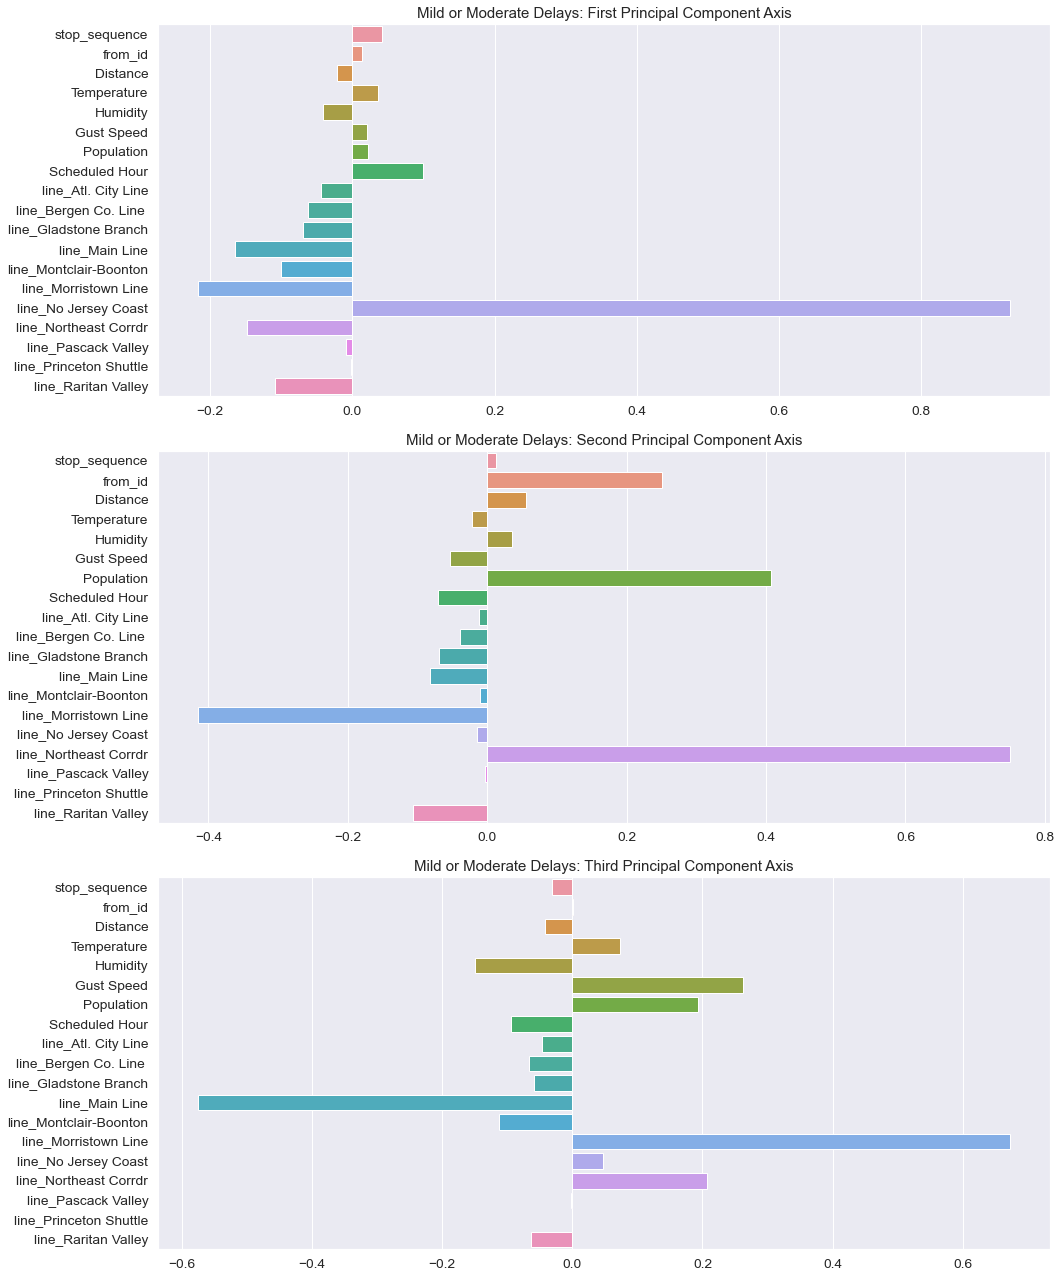

In [34]:
#Visualise PCA_0 Results
fig, ax = plt.subplots(3, 1, figsize=(15, 18))
sns.barplot(x=pca_0.components_[0], y=inputs3_0_norm.columns, orient='h', ax=ax[0])
sns.barplot(x=pca_0.components_[1], y=inputs3_0_norm.columns, orient='h', ax=ax[1])
sns.barplot(x=pca_0.components_[2], y=inputs3_0_norm.columns, orient='h', ax=ax[2])

ax[0].set_title('Mild or Moderate Delays: First Principal Component Axis')
ax[1].set_title('Mild or Moderate Delays: Second Principal Component Axis')
ax[2].set_title('Mild or Moderate Delays: Third Principal Component Axis')
fig.tight_layout()

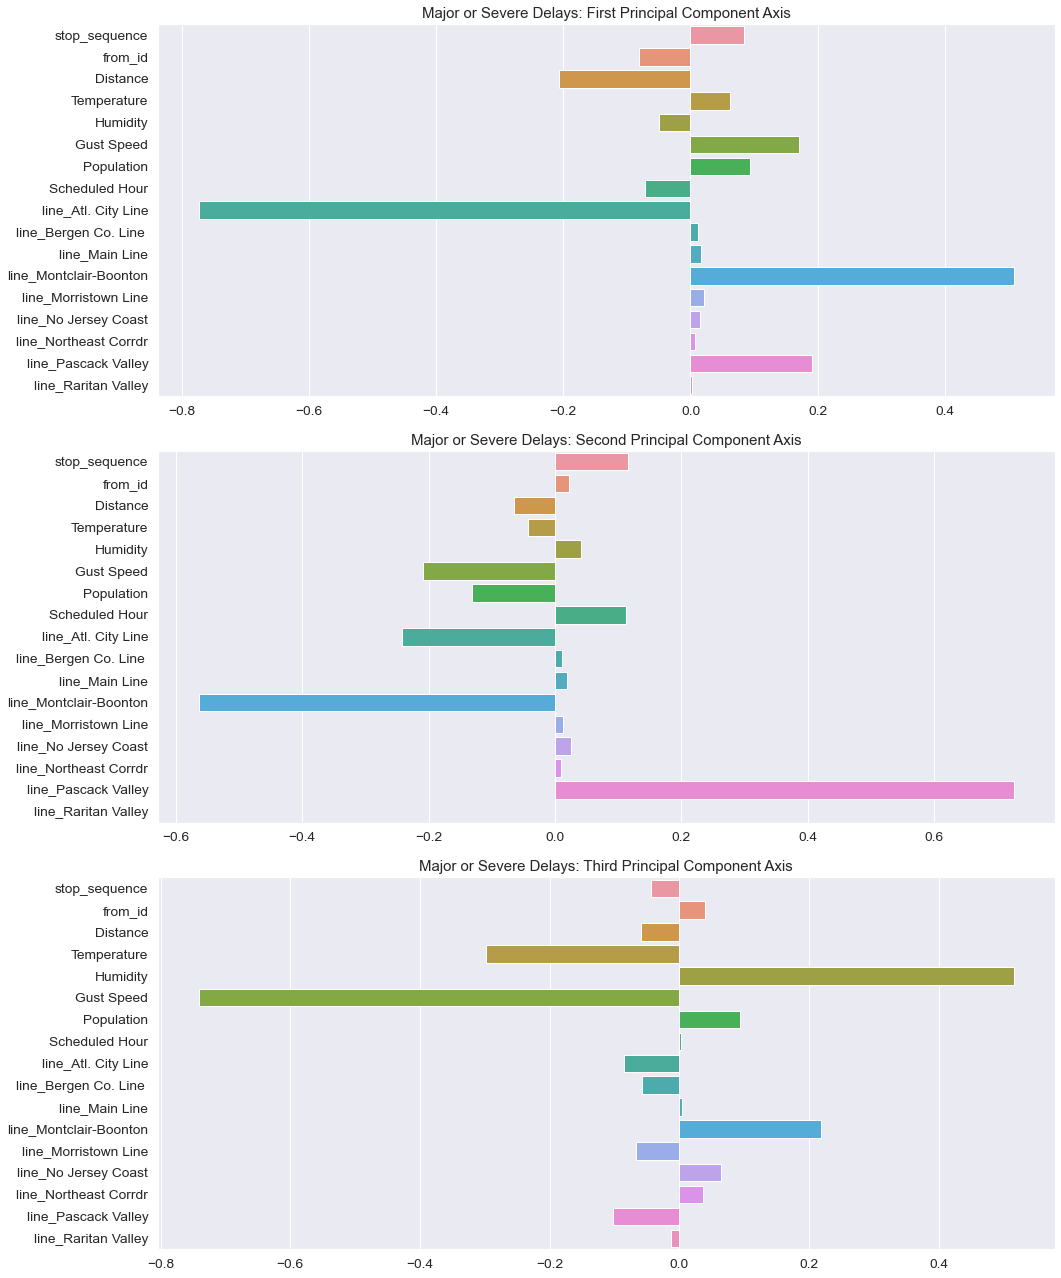

In [35]:
#Visualise PCA_1 Results
fig, ax = plt.subplots(3, 1, figsize=(15, 18))
sns.barplot(x=pca_1.components_[0], y=inputs3_1_norm.columns, orient='h', ax=ax[0])
sns.barplot(x=pca_1.components_[1], y=inputs3_1_norm.columns, orient='h', ax=ax[1])
sns.barplot(x=pca_1.components_[2], y=inputs3_1_norm.columns, orient='h', ax=ax[2])

ax[0].set_title('Major or Severe Delays: First Principal Component Axis')
ax[1].set_title('Major or Severe Delays: Second Principal Component Axis')
ax[2].set_title('Major or Severe Delays: Third Principal Component Axis')
fig.tight_layout()

From the plots above, we observe that some lines do indeed play significant roles in contributing to Minor/Moderate and Major/Severe Delays. In general, we observe that the line predictors tend to matter more than the non-line predictors as their magnitude tends to be greater. As these principal components are orthogonal to each other, these results provide some unique insight as to which lines should be more carefully managed for the delays that they tend to be prone to.

# Conclusion
This project has studied how different predictors like distance, line, weather, population could be related to the train delay timings. This is a challenging dataset to handle because most delays tend to be minor, making the dataset very skewed. We observed that different models tend to be useful in different scenarios and briefly summarise our findings below:
 * <b> Kernel Regression</b>: Not very useful for making predictions on delay timings as dataset is overcrowded by minor delays. Especially inaccurate in predicting significant delays.
 * <b> Decision Trees</b>: Our best performing model in classifying delays, especially when model ensembling is used. From preliminary analysis, significant delays are decently classified too.
 * <b> Neural Networks</b>: A close contender to the decision tree classifier in terms of accuracy, but unable to classify significant delays well.
 * <b> GMM</b>: Does not classify insignificant delays as well as Decision Trees or Neural Networks, but has better precision and recall when predicting significant delays.
 * <b> PCA</b>: Useful for identifying specific predictors associated with insignificant and significant delays.

Another general observation we make is that none of our models achieve very high classification scores (0.9+), which means that there might be other predictors beyond this dataset that strongly affect the train delay timings. This is actually not surprising as rail reliability is a very complex emergent behaviour that accounts for not just operational parameters that we analysed, but also technical parameters (design, age, quality) and maintenance parameters (condition, skill). These factors are much harder to quantify but may be needed to make better classifications.

# References

<u> Datasets </u>
1. Rail dataset: https://www.kaggle.com/pranavbadami/nj-transit-amtrak-nec-performance?select=2020_05.csv
2. Weather dataset: https://www.wunderground.com/history/daily/us/nj/newark/KEWR/date/2020-5-1 (daily)
3. Population dataset: https://nj.gov/health/fhs/primarycare/documents/Rural%20NJ%20density2015-revised%20municpalities.pdf
4. Station coordinates dataset: https://njogis-newjersey.opendata.arcgis.com/datasets/NJTRANSIT::rail-stations-of-nj-transit

<u> Miscellaneous </u>
 * Coordinates to distance: https://www.usgs.gov/faqs/how-much-distance-does-a-degree-minute-and-second-cover-your-maps?qt-news_science_products=0#qt-news_science_products